# Advertisement Classification
### Task: To predict whether a comment is ad or not

### Importing Packages

In [1]:
## import all neccessary packages
import numpy as np
import pandas as pd
import regex as re

#NLP Packages
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Packages for splitting, evaluating,visualization, bagofwords and hyperparameter tuning

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, confusion_matrix

#Classifier Packages
from sklearn.tree import ExtraTreeClassifier,DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier, LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Package to turn off warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KRITIKA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Train and Test Dataset

In [2]:
dftrain = pd.read_csv("train.csv")
dftest = pd.read_csv("test.csv")

### Data Exploration

In [3]:
dftrain.info()
print("\n");print("\n")
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1157 non-null   object
 1   AUTHOR      1157 non-null   object
 2   DATE        1019 non-null   object
 3   CONTENT     1157 non-null   object
 4   CLASS       1157 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 45.3+ KB




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          799 non-null    int64 
 1   COMMENT_ID  799 non-null    object
 2   AUTHOR      799 non-null    object
 3   DATE        692 non-null    object
 4   CONTENT     799 non-null    object
dtypes: int64(1), object(4)
memory usage: 31.3+ KB


Lets check for null values,

In [4]:
print("Sum of null values in Train data:\n",dftrain.isnull().sum(),"\n")
print("Sum of null values in Test data:\n",dftrain.isnull().sum(),"\n")

Sum of null values in Train data:
 COMMENT_ID      0
AUTHOR          0
DATE          138
CONTENT         0
CLASS           0
dtype: int64 

Sum of null values in Test data:
 COMMENT_ID      0
AUTHOR          0
DATE          138
CONTENT         0
CLASS           0
dtype: int64 



Date column has null values, but we dont require Date, so thats not a problem.

Lets check for balance in dataset,

In [5]:
dftrain.value_counts('CLASS')

CLASS
1    586
0    571
dtype: int64

Data seems to be perfectly balanced. 

## Data Preprocessing

 Lets perform some preprocessing here
1) Remove unwanted columns <br>                                                                                                2) Remove the stopwords <br> 
3) Remove the hyperlinks <br> 
4) Make all letters lowercase <br> 
5) Perform BagOfWords encoding <br> 

We will create seprate functions for each and call them for train and test data seprately.

In [6]:
def removeCol(nameOfCol,data): 
    
    '''To remove unwanted columns'''
    
    data.drop(columns=nameOfCol,inplace=True)

In [7]:
def replaceLinks(data):
    
    ''' To replace links with a single semantic notation'''
    
    data=str(data)
    data=re.sub(r"http\S+",'url',data)
    data=re.sub(r"watch\S+",'url',data)
    return data

In [8]:

def removeSymbols(data):
    ''' To replace special characters with space '''
    data = re.sub('[^a-zA-Z]', ' ', data)
    return data

In [9]:
def makeLower(data):
    
    '''To make all letters lowercase so that A and a are not treated differntly. 
        We could have done this using argument is CountVectorizer, but its better to create a seprate function'''

    data = data.lower()
    return data

In [10]:
def removeStopwordsAndStemming(data):
    
    '''To remove stop words in english which do not add any value to data,
    and to performing stemming to convert similar words to their stem root form'''
    
    ps=PorterStemmer()
    words = data.split()
    data = [ps.stem(word) for word in words if not word in stopwords.words('english')]
    data = ' '.join(data)
    return data

Preprocessing the Train data by calling all the functions:

In [11]:
removeCol(["COMMENT_ID","AUTHOR","DATE"],dftrain)
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: replaceLinks(x))
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: removeSymbols(x))
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: makeLower(x))
dftrain['CONTENT'] = dftrain['CONTENT'].apply(lambda x: removeStopwordsAndStemming(x))

Separting the label and feature:

In [12]:
X=dftrain["CONTENT"]
y=dftrain["CLASS"]

In [14]:
X

0                  huh anyway check tube channel kobyoshi
1                            shake sexi ass channel enjoy
2                                               url check
3                                        subscrib channel
4                               u check channel tell next
                              ...                        
1152    check new mixtap check new mixtap check new mi...
1153                                       waka waka rule
1154    love song two reason africa born beauti south ...
1155                                                  wow
1156                                     shakira u wiredo
Name: CONTENT, Length: 1157, dtype: object

### Model Creation and Evaluation

Train test split:

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=57, stratify=y)

Applying Bag of Words on x_train and x_test to encode each word to be understood by models,

In [35]:
cv=CountVectorizer()
x_train_cv=cv.fit_transform(x_train)
x_test_cv=cv.transform(x_test)

Also, tried lemmatization,TF-IDF and tuning the values of min_df and max_df in Countvectorizer, but there was no improvement in the results.

Lets create a loop to fit all classifiers and evaluate the classifier on the basis of their roc_auc_score.
We will store classifier name and their respective roc_auc_score in a data frame.

In [29]:
# Dictionary of all classifiers 
classifiers = {
             'ExtraTreeClassifier': ExtraTreeClassifier(),
             'DecisionTreeClassifier': DecisionTreeClassifier(), 
             'KNeighborsClassifier': KNeighborsClassifier(),
             'SGD Classifier': SGDClassifier(),
             'RidgeClassifier': RidgeClassifier(),
             'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
             'GaussianProcessClassifier': GaussianProcessClassifier(),
             'AdaBoostClassifier': AdaBoostClassifier(),
             'GradientBoostingClassifier': GradientBoostingClassifier(),
             'BaggingClassifier': BaggingClassifier(),
             'RandomForestClassifier': RandomForestClassifier(),
             'GaussianNB': GaussianNB(),
             'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
             'LinearSVC': LinearSVC(),
             'LogisticRegression': LogisticRegression(),
             'MultinomialNB': MultinomialNB(),
             'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
             'SVC': SVC(),
             'NuSVC': NuSVC(), 
             'XGBClassifier': XGBClassifier(),
             'LGBMClassifier': LGBMClassifier(),
             'CatBoostClassifier': CatBoostClassifier()
             }

In [31]:
# List to store roc_auc_score
roc_auc_list=[]
# List to store Classifier name
clf_name_list=[]
#List to store the fitted model
fitted_model=[]

for i, (clf_name,clf) in enumerate(classifiers.items()):
    
    print('Running Model',clf_name)
    #For classifier that require only array of values
    if clf_name == 'GaussianNB' or 'GaussianProcessClassifier' or 'LinearDiscriminantAnalysis' or 'PassiveAggressiveClassifier':
        clf.fit(x_train_cv.toarray(),y_train) #fit
        predictions = clf.predict(x_test_cv.toarray()) #predict
    
    #For all other classifiers 
    else:
        clf.fit(x_train_cv,y_train) #fit
        predictions = clf.predict(x_test_cv) #predict
        
    #Adding all the value to the empty list created
    fitted_model.append(clf)
    roc_auc_list.append(roc_auc_score(y_test,predictions)*100)
    clf_name_list.append(clf_name)
    print("{} Model ran succesfully\n".format(clf_name))

Running Model ExtraTreeClassifier
ExtraTreeClassifier Model ran succesfully

Running Model DecisionTreeClassifier
DecisionTreeClassifier Model ran succesfully

Running Model KNeighborsClassifier
KNeighborsClassifier Model ran succesfully

Running Model SGD Classifier
SGD Classifier Model ran succesfully

Running Model RidgeClassifier
RidgeClassifier Model ran succesfully

Running Model PassiveAggressiveClassifier
PassiveAggressiveClassifier Model ran succesfully

Running Model GaussianProcessClassifier
GaussianProcessClassifier Model ran succesfully

Running Model AdaBoostClassifier
AdaBoostClassifier Model ran succesfully

Running Model GradientBoostingClassifier
GradientBoostingClassifier Model ran succesfully

Running Model BaggingClassifier
BaggingClassifier Model ran succesfully

Running Model RandomForestClassifier
RandomForestClassifier Model ran succesfully

Running Model GaussianNB
GaussianNB Model ran succesfully

Running Model LinearDiscriminantAnalysis
LinearDiscriminantAna

131:	learn: 0.3028603	total: 2.92s	remaining: 19.2s
132:	learn: 0.3021240	total: 2.93s	remaining: 19.1s
133:	learn: 0.3013714	total: 2.94s	remaining: 19s
134:	learn: 0.3006055	total: 2.96s	remaining: 18.9s
135:	learn: 0.2994044	total: 2.97s	remaining: 18.9s
136:	learn: 0.2988236	total: 2.98s	remaining: 18.8s
137:	learn: 0.2979928	total: 3s	remaining: 18.7s
138:	learn: 0.2972506	total: 3.02s	remaining: 18.7s
139:	learn: 0.2963969	total: 3.03s	remaining: 18.6s
140:	learn: 0.2958598	total: 3.04s	remaining: 18.5s
141:	learn: 0.2954898	total: 3.05s	remaining: 18.4s
142:	learn: 0.2947917	total: 3.06s	remaining: 18.4s
143:	learn: 0.2939547	total: 3.08s	remaining: 18.3s
144:	learn: 0.2935134	total: 3.1s	remaining: 18.3s
145:	learn: 0.2927984	total: 3.11s	remaining: 18.2s
146:	learn: 0.2920694	total: 3.12s	remaining: 18.1s
147:	learn: 0.2918899	total: 3.13s	remaining: 18s
148:	learn: 0.2912167	total: 3.15s	remaining: 18s
149:	learn: 0.2904581	total: 3.16s	remaining: 17.9s
150:	learn: 0.2898370	

292:	learn: 0.2401378	total: 5.12s	remaining: 12.4s
293:	learn: 0.2396551	total: 5.13s	remaining: 12.3s
294:	learn: 0.2395849	total: 5.15s	remaining: 12.3s
295:	learn: 0.2395129	total: 5.16s	remaining: 12.3s
296:	learn: 0.2393387	total: 5.17s	remaining: 12.2s
297:	learn: 0.2390057	total: 5.18s	remaining: 12.2s
298:	learn: 0.2388732	total: 5.2s	remaining: 12.2s
299:	learn: 0.2387012	total: 5.21s	remaining: 12.2s
300:	learn: 0.2385760	total: 5.22s	remaining: 12.1s
301:	learn: 0.2383665	total: 5.24s	remaining: 12.1s
302:	learn: 0.2382257	total: 5.25s	remaining: 12.1s
303:	learn: 0.2379609	total: 5.26s	remaining: 12s
304:	learn: 0.2377721	total: 5.28s	remaining: 12s
305:	learn: 0.2376037	total: 5.29s	remaining: 12s
306:	learn: 0.2374837	total: 5.3s	remaining: 12s
307:	learn: 0.2373288	total: 5.32s	remaining: 11.9s
308:	learn: 0.2371543	total: 5.33s	remaining: 11.9s
309:	learn: 0.2370531	total: 5.34s	remaining: 11.9s
310:	learn: 0.2367343	total: 5.36s	remaining: 11.9s
311:	learn: 0.2365934	

457:	learn: 0.2123535	total: 7.35s	remaining: 8.7s
458:	learn: 0.2122300	total: 7.36s	remaining: 8.68s
459:	learn: 0.2121545	total: 7.38s	remaining: 8.66s
460:	learn: 0.2119637	total: 7.39s	remaining: 8.64s
461:	learn: 0.2119125	total: 7.4s	remaining: 8.62s
462:	learn: 0.2118639	total: 7.41s	remaining: 8.6s
463:	learn: 0.2117487	total: 7.42s	remaining: 8.57s
464:	learn: 0.2116489	total: 7.43s	remaining: 8.55s
465:	learn: 0.2115488	total: 7.45s	remaining: 8.53s
466:	learn: 0.2114672	total: 7.46s	remaining: 8.51s
467:	learn: 0.2113610	total: 7.47s	remaining: 8.49s
468:	learn: 0.2112632	total: 7.48s	remaining: 8.47s
469:	learn: 0.2112143	total: 7.5s	remaining: 8.45s
470:	learn: 0.2111518	total: 7.51s	remaining: 8.43s
471:	learn: 0.2109652	total: 7.52s	remaining: 8.41s
472:	learn: 0.2108840	total: 7.54s	remaining: 8.4s
473:	learn: 0.2108169	total: 7.55s	remaining: 8.38s
474:	learn: 0.2107250	total: 7.56s	remaining: 8.36s
475:	learn: 0.2106091	total: 7.57s	remaining: 8.34s
476:	learn: 0.210

618:	learn: 0.1937050	total: 9.44s	remaining: 5.81s
619:	learn: 0.1936309	total: 9.46s	remaining: 5.79s
620:	learn: 0.1931888	total: 9.47s	remaining: 5.78s
621:	learn: 0.1931343	total: 9.48s	remaining: 5.76s
622:	learn: 0.1930753	total: 9.49s	remaining: 5.74s
623:	learn: 0.1930160	total: 9.5s	remaining: 5.73s
624:	learn: 0.1929254	total: 9.52s	remaining: 5.71s
625:	learn: 0.1928632	total: 9.53s	remaining: 5.69s
626:	learn: 0.1927958	total: 9.54s	remaining: 5.67s
627:	learn: 0.1925773	total: 9.55s	remaining: 5.66s
628:	learn: 0.1924253	total: 9.56s	remaining: 5.64s
629:	learn: 0.1923673	total: 9.57s	remaining: 5.62s
630:	learn: 0.1923002	total: 9.59s	remaining: 5.61s
631:	learn: 0.1922510	total: 9.6s	remaining: 5.59s
632:	learn: 0.1921328	total: 9.62s	remaining: 5.58s
633:	learn: 0.1919943	total: 9.63s	remaining: 5.56s
634:	learn: 0.1916487	total: 9.64s	remaining: 5.54s
635:	learn: 0.1915983	total: 9.65s	remaining: 5.52s
636:	learn: 0.1915443	total: 9.66s	remaining: 5.51s
637:	learn: 0.

779:	learn: 0.1712248	total: 11.5s	remaining: 3.25s
780:	learn: 0.1711595	total: 11.5s	remaining: 3.23s
781:	learn: 0.1711062	total: 11.5s	remaining: 3.22s
782:	learn: 0.1709887	total: 11.6s	remaining: 3.2s
783:	learn: 0.1709345	total: 11.6s	remaining: 3.19s
784:	learn: 0.1708673	total: 11.6s	remaining: 3.17s
785:	learn: 0.1707593	total: 11.6s	remaining: 3.16s
786:	learn: 0.1702582	total: 11.6s	remaining: 3.14s
787:	learn: 0.1701966	total: 11.6s	remaining: 3.13s
788:	learn: 0.1700632	total: 11.6s	remaining: 3.11s
789:	learn: 0.1697771	total: 11.7s	remaining: 3.1s
790:	learn: 0.1696648	total: 11.7s	remaining: 3.08s
791:	learn: 0.1695476	total: 11.7s	remaining: 3.07s
792:	learn: 0.1692665	total: 11.7s	remaining: 3.06s
793:	learn: 0.1689735	total: 11.7s	remaining: 3.04s
794:	learn: 0.1689154	total: 11.7s	remaining: 3.02s
795:	learn: 0.1688580	total: 11.7s	remaining: 3.01s
796:	learn: 0.1687634	total: 11.8s	remaining: 2.99s
797:	learn: 0.1687024	total: 11.8s	remaining: 2.98s
798:	learn: 0.

941:	learn: 0.1499434	total: 13.7s	remaining: 843ms
942:	learn: 0.1498966	total: 13.7s	remaining: 829ms
943:	learn: 0.1498131	total: 13.7s	remaining: 814ms
944:	learn: 0.1497668	total: 13.7s	remaining: 800ms
945:	learn: 0.1496878	total: 13.8s	remaining: 785ms
946:	learn: 0.1492455	total: 13.8s	remaining: 770ms
947:	learn: 0.1491454	total: 13.8s	remaining: 756ms
948:	learn: 0.1490993	total: 13.8s	remaining: 741ms
949:	learn: 0.1489638	total: 13.8s	remaining: 726ms
950:	learn: 0.1488658	total: 13.8s	remaining: 712ms
951:	learn: 0.1488223	total: 13.8s	remaining: 697ms
952:	learn: 0.1487791	total: 13.8s	remaining: 683ms
953:	learn: 0.1487367	total: 13.9s	remaining: 668ms
954:	learn: 0.1486404	total: 13.9s	remaining: 653ms
955:	learn: 0.1485976	total: 13.9s	remaining: 639ms
956:	learn: 0.1485009	total: 13.9s	remaining: 625ms
957:	learn: 0.1484232	total: 13.9s	remaining: 610ms
958:	learn: 0.1483324	total: 13.9s	remaining: 596ms
959:	learn: 0.1480030	total: 13.9s	remaining: 581ms
960:	learn: 

Lets create a Data Frame using the values in three list we created,

In [33]:
modeldf=pd.DataFrame({'ModelName':clf_name_list,'RocAucScore':roc_auc_list, 'fitted_model':fitted_model})
modeldf
#Sort the values to get Highest Roc_Auc_Score
modeldf=modeldf.sort_values(by='RocAucScore', ascending=False)
modeldf

,ModelName,RocAucScore,fitted_model
19,XGBClassifier,96.595302,"XGBClassifier(base_score=0.5, booster='gbtree'..."
20,LGBMClassifier,96.141838,LGBMClassifier()
10,RandomForestClassifier,95.732977,"(DecisionTreeClassifier(max_features='auto', r..."
1,DecisionTreeClassifier,95.294380,DecisionTreeClassifier()
9,BaggingClassifier,94.461790,(DecisionTreeClassifier(random_state=167150283...
0,ExtraTreeClassifier,94.446922,ExtraTreeClassifier()
17,SVC,94.357716,SVC()
13,LinearSVC,93.978591,LinearSVC()
14,LogisticRegression,93.978591,LogisticRegression()
3,SGD Classifier,93.963723,SGDClassifier()


Plotting the roc_auc_score and classifiers

<AxesSubplot:xlabel='ModelName'>

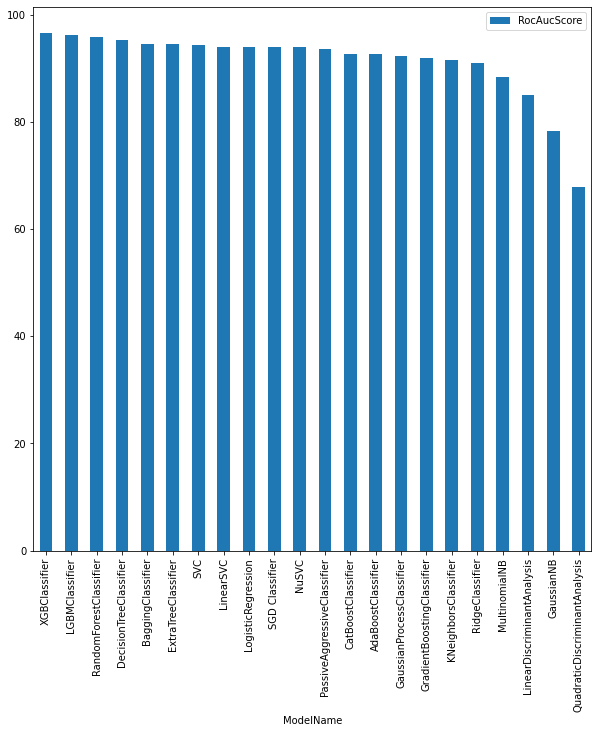

In [34]:
modeldf.plot(x='ModelName', y='RocAucScore', kind='bar',figsize=(10,10))

 Lets try for voting classifier of for XGB, Random Forest and LGBM,

In [19]:
from sklearn.ensemble import VotingClassifier
clf1= XGBClassifier()
clf2= RandomForestClassifier()
clf3= LGBMClassifier()
eclf1 = VotingClassifier(estimators=[
('xgb', clf1), ('rf', clf2), ('lgbm', clf3)], voting='hard')
eclf1.fit(x_train_cv.astype('float32'), y_train)
predictions = eclf1.predict(x_test_cv.astype('float32'))
roc_auc_score(y_test,predictions)

[04:19:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9615670532262861

There is no signifcant change in roc_auc_score, lets try hyperparameter tuning.

### Hyperparameter Tuning

#### Hyperparameter tuning of Random Forest:

In [27]:
from sklearn.model_selection import GridSearchCV
# parameter grid for values to be tuned
param_grid = {
    'criterion' : ['gini','entropy'],
    'bootstrap': [True,False],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,5,3],
    'min_samples_split': [1,2],
    'n_estimators': [100,50,190]
}

#Model to be tuned
rf = RandomForestClassifier() 
#Calling GridSearch
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          verbose=1, cv = 5, n_jobs = -1, scoring='roc_auc')
grid_search.fit(x_train_cv, y_train) #fit

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 3],
                         'min_samples_split': [1, 2],
                         'n_estimators': [100, 50, 190]},
             scoring='roc_auc', verbose=1)

In [29]:
grid_search.best_estimator_

RandomForestClassifier(max_features='sqrt', n_estimators=190)

In [30]:
rf=RandomForestClassifier(max_features='sqrt', n_estimators=190)

In [31]:
#fit and predict
rf.fit(x_train_cv,y_train)
pred_rf=rf.predict(x_test_cv)
roc_auc_score(y_test,pred_rf)

0.9615670532262861

#### Hyperparameter tuning of XGBoost:

In [32]:
param_grid={
 "learning_rate"    : [0.05, 0.10, 0.20, 0.30 ] ,
 "max_depth"        : [ 3, 5, 8, 12, 15],
 "min_child_weight" : [ 1, 3, 7 ],
 "gamma"            : [ 0.0, 0.2 , 0.5 ],
 "colsample_bytree" : [ 0.3, 0.5, 1 ]
    }

#Model to be tuned
xgb = XGBClassifier()
#Calling GridSearch
grid_search1 = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          verbose=1, cv = 5, n_jobs = -1, scoring='roc_auc')

grid_search1.fit(x_train_cv, y_train) #fit

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[04:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [34]:
grid_search1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
xg=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=15,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xg.fit(x_train_cv,y_train)
pred_xg=xg.predict(x_test_cv)
roc_auc_score(y_test,pred_xg)

[04:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9612696996729112

#### Hyperparameter tuning of LGBM:

In [36]:
param_grid={'num_leaves': [10,31], 
             'min_child_samples': [100,20,500], 
             'min_child_weight': [1e-5, 1, 1e1, 1e2], 
             'colsample_bytree': [0.4,0.9],
             'reg_alpha': [0, 1e-1, 10,100],
             'reg_lambda': [0, 1e-1,100]
            }
#Model to be tuned
lgbm = LGBMClassifier()
#Calling GridSearch
grid_search2 = GridSearchCV(estimator = lgbm, param_grid = param_grid, 
                          verbose=1, cv = 5, n_jobs = -1, scoring='roc_auc')

grid_search2.fit(x_train_cv.astype('float32'), y_train) #fit

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.9],
                         'min_child_samples': [100, 20, 500],
                         'min_child_weight': [1e-05, 1, 10.0, 100.0],
                         'num_leaves': [10, 31], 'reg_alpha': [0, 0.1, 10, 100],
                         'reg_lambda': [0, 0.1, 100]},
             scoring='roc_auc', verbose=1)

In [37]:
grid_search2.best_estimator_

LGBMClassifier(colsample_bytree=0.9, min_child_weight=1, reg_alpha=0.1,
               reg_lambda=0.1)

In [38]:
lgbm=LGBMClassifier(colsample_bytree=0.9, min_child_weight=1, reg_alpha=0.1,
               reg_lambda=0.1)
lgbm.fit(x_train_cv.astype('float32'),y_train)
pred_lgbm=lgbm.predict(x_test_cv.astype('float32'))
roc_auc_score(y_test,pred_lgbm)

0.9614183764495986

#### Plotting ROC Curves for all tuned models

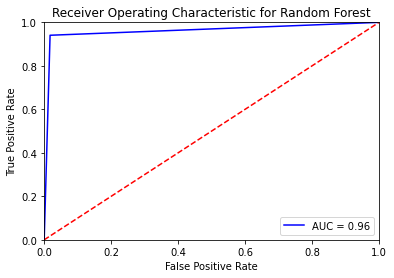

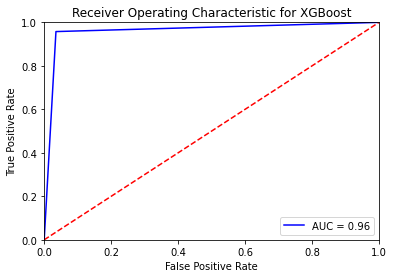

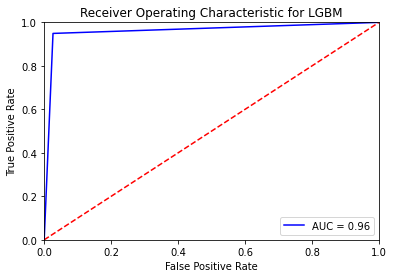

In [54]:
predictedValues={'Random Forest':pred_rf,'XGBoost':pred_xg,'LGBM':pred_lgbm}

for i, (name,predVal) in enumerate(predictedValues.items()):
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predVal)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic for {}'.format(name))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

<b>Hyperparameter tuning did not bring a signficant change, the roc_auc_score range was between 95.5-96.5 throughout, <br>
However there was consistency observed in parameters of RandomForestClassifier and,it showed least False Positive rate. <br>
So, going ahead with Random Forest Classifier.

### Processing Test data

Preprocessing the test data by calling the above defined functions:

In [39]:
#Storing the IDs seperately 
ID=dftest['ID']
removeCol(["ID","COMMENT_ID","AUTHOR","DATE"],dftest)
dftest['CONTENT'] = dftest['CONTENT'].apply(lambda x: replaceLinks(x))
dftest['CONTENT'] = dftest['CONTENT'].apply(lambda x: removeSymbols(x))
dftest['CONTENT'] = dftest['CONTENT'].apply(lambda x: makeLower(x))
dftest['CONTENT'] = dftest['CONTENT'].apply(lambda x: removeStopwordsAndStemming(x))

Applying BagOfWords using the CountVectorizer fitted while training:

In [40]:
test=cv.transform(dftest['CONTENT'])

### Final Submission

Final prediction using RandomForestClassfier with tuned paramters:

In [41]:
rfc=RandomForestClassifier(max_features='sqrt', n_estimators=190)
rfc.fit(x_train_cv,y_train) #fit

RandomForestClassifier(max_features='sqrt', n_estimators=190)

In [42]:
finalPred=rfc.predict(test) #predict

In [43]:
#creating a dataframe to submit predicted results
submit=pd.DataFrame({'ID':ID, 'CLASS':finalPred})

#Saving dataframe as csv
submit.to_csv("Submissionrfc1.csv",index = False)